In [1]:
import pandas as pd
import numpy as np
from util import BinanceArchive, COLUMNS
from datetime import datetime
import matplotlib

In [2]:
# spot data
spot_params = {
    "symbol": "BTCUSDT",
    "trading_type": 'spot',
    "mkt_data_type": 'klines',
    "interval": '1h',
    "start_date": datetime(2021, 6, 26),
    "end_date": datetime(2021, 9, 24)
}
spot_ba = BinanceArchive.from_params(spot_params)
spot_df = spot_ba.load()
spot_df = spot_df[["Open_time", "Open", "High", "Low", "Close", "Volume"]]
spot_df.rename(columns={"Open_time": "timestamp",
                        "Open": "spot_open",
                        "High": "spot_high",
                        "Low": "spot_low",
                        "Close": "spot_close",
                        "Volume": "spot_volume"},
               inplace=True)

# futures data using 210924 contract
futures_params = {
    "symbol": "BTCUSDT_210924",
    "trading_type": 'um',
    "mkt_data_type": 'klines',
    "interval": '1h',
    "start_date": datetime(2021, 6, 26),
    "end_date": datetime(2021, 9, 24)
}
futures_ba = BinanceArchive.from_params(futures_params)
futures_df = futures_ba.load()
futures_df = futures_df[["Open_time", "Open", "High", "Low", "Close", "Volume"]]
futures_df.rename(columns={"Open_time": "timestamp",
                           "Open": "futures_open",
                           "High": "futures_high",
                           "Low": "futures_low",
                           "Close": "futures_close",
                           "Volume": "futures_volume"},
                  inplace=True)

File not found: https://data.binance.vision/data/futures/um/daily/klines/BTCUSDT_210924/1h/BTCUSDT_210924-1h-2021-07-13.zip


In [3]:
df = pd.merge(spot_df, futures_df, on="timestamp")
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
maturity = datetime(2021, 9, 24, 23, 59, 59)
df['days_to_maturity'] = (maturity - df['timestamp']).dt.days
df = df[df['days_to_maturity'] > 0]
# assuming exponential compounding and zero interest rates, calculate funding spreads
df['fs'] = np.log(df['futures_close'] / df['spot_close']) / (df['days_to_maturity'] / 365)
df.reset_index(drop=True, inplace=True)
df.set_index('timestamp', inplace=True)
df.head()

,spot_open,spot_high,spot_low,spot_close,spot_volume,futures_open,futures_high,futures_low,futures_close,futures_volume,days_to_maturity,fs
timestamp,,,,,,,,,,,,
2021-06-26 00:00:00,31576.09,32222.00,31300.00,32000.00,5253.841553,32024.9,32683.9,31708.5,32442.5,134.089,90,0.055697
2021-06-26 01:00:00,32000.00,32046.51,31519.00,31968.35,2521.206402,32440.1,32500.0,31933.8,32437.5,86.708,90,0.059085
2021-06-26 02:00:00,31970.03,32082.46,31682.02,31943.48,1982.845199,32452.1,32535.0,32121.4,32391.3,48.358,90,0.056461
2021-06-26 03:00:00,31943.49,32268.91,31933.08,31977.59,2309.054834,32398.5,32715.8,32374.4,32414.4,44.755,90,0.055023
2021-06-26 04:00:00,31979.71,32436.20,31869.69,32354.36,2637.567755,32404.3,32860.2,32298.6,32781.4,38.964,90,0.053178


In [4]:
df.describe()

,spot_open,spot_high,spot_low,spot_close,spot_volume,futures_open,futures_high,futures_low,futures_close,futures_volume,days_to_maturity,fs
count,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000
mean,41470.039198,41690.524634,41245.806205,41477.067669,2356.236099,41778.714916,42011.640572,41539.288508,41784.171764,114.073488,45.196998,0.070090
std,6563.873895,6577.021970,6542.892632,6561.239572,1707.804084,6591.551766,6605.039781,6566.159140,6587.929531,131.246752,25.989794,0.056435
min,29420.420000,29706.830000,29278.000000,29420.500000,461.409380,29453.700000,29770.400000,29292.400000,29445.000000,16.539000,1.000000,-1.059403
25%,34308.997500,34492.852500,34118.125000,34312.462500,1376.599161,34651.125000,34839.875000,34485.825000,34653.350000,58.824500,23.000000,0.045400
50%,43637.780000,43932.125000,43360.765000,43653.380000,1895.184217,43892.650000,44155.700000,43593.200000,43897.500000,85.276000,45.000000,0.067670
75%,47183.580000,47390.680000,46983.917500,47183.590000,2760.974307,47452.200000,47714.625000,47240.075000,47445.875000,133.412000,67.000000,0.090392
max,52698.010000,52920.000000,52615.430000,52698.000000,29942.698524,53238.100000,53479.600000,53157.600000,53240.200000,3959.252000,90.000000,0.321847


<AxesSubplot:xlabel='timestamp'>

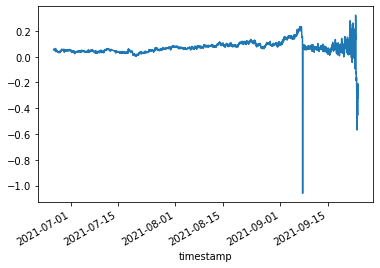

In [5]:
df['fs'].plot(kind='line')